# Final Project - Advanced Topics in Computer Science 8
Yehonatan Peisakhovsky yehonatan-pe@campus.technion.ac.il ?????????
Ido Zuckerman ido.z@campus.technion.ac.il 323102830

## Topic
Strategic classification, specifically the behavior of strategic suppliers in information retrieval.

## Introduction
In the domain of information retrieval, which is closely related to recommendation systems, the objective of the information retrieval system is to retrieve relevant information from a large collection of data in response to a user's query. It does so by finding the documents with the highest probability of being relevant to the user’s query.
But the objective of the content creators, the ones who are creating the data, is to get as many people as possible to read their content (like news sites), buy products from them (like amazon, eBay and etc.) or to expose visitors to advertisement on the site. For all those reasons, content creators objective is to get people to chose their document to consume.
Because content creators want the highest exposure (as it usually translates to more users consuming their data), they would want to be ranked as high as possible to as many queries as possible. So, content creators might change their content, to be ranked higher and receive higher exposure, even if the changes are superficial and meant only for the benefit of higher ratings.
And because not all queries carry the same value (for example, a user searching for a new phone carries much more value to an Ecommerce site than a user searching for bottle water), then content creators might want to tailor their data to fit best to the higher value queries.
In our work, we chose to explore how such strategic behavior of the content creators affects the overall performance of the information retrieval system, and the affect of the strategic behavior of the content creators on their revenue.


## Research Question
How does strategic behavior of content creators affect system integrity?
How does strategic behavior of content creators affect their revenue?


## Assumptions
Our assumptions are:
1.	Different information retrieval systems will show different behavior exposed to
2.	Using strategic behavior will lead to decreased performance of the information retrieval system.
3.	Strategic behavior of content creators will lead to an increase in their revenue only to a certain point, meaning if there are too many strategic agents, strategic behavior might not add additional revenue.



## Methods and Experiments
????? (expiremnts and metrics)

## Results

In [1]:
from enviorment import Env
from utils import *
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import random
from collections import defaultdict
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idozu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Hyperparameters

In [2]:
amount_of_queries = 50
k = 5
Epochs = 3

#### Preprocess

In [3]:
docs, queries, rel = create_documents_queries_and_relevence()
queries_with_relevant_docs = list(rel.keys())
queries = {k: queries[k] for k in queries_with_relevant_docs}
docs, queries = preprocess_data(docs, queries)

# Temp Experiments

In [4]:
def run_exp(strategic_per_nums, number_of_word_to_add_nums, model, k=4, strategy="top_k_softmax"):
    agents_params = {"strategy": strategy, "k": k, "t": 100}
    print(f"\nModel: {model}\tstrategic_per: {strategic_per_nums}\tnumber_of_word_to_add: {number_of_word_to_add_nums}"
          f"\tstrategy: {strategy}\tk: {k}")
    # Preprocess
    docs, queries, rel = create_documents_queries_and_relevence()
    queries_with_relevant_docs = list(rel.keys())
    queries = {k: queries[k] for k in queries_with_relevant_docs}
    docs, queries = preprocess_data(docs, queries)


    # Chosen queries to work with and do cross validation
    chosen_queries = [x for x in queries.keys()][:amount_of_queries]
    cv = KFold(5)
    undisturbed_ndcgs = defaultdict(float)
    disturbed_ndcgs = defaultdict(float)
    agents_values = defaultdict(float)
    for strategic_per in tqdm(strategic_per_nums):
        for number_of_word_to_add in number_of_word_to_add_nums:
            # original ndcg without changing the documents
            undisturbed_ndcg = []
            # Ndcg after the change
            disturbed_ndcg = []
            agents_value = []
            for train_indices, test_indices in cv.split(chosen_queries):
                # The ids of the queries used to train,
                # they actually matter just when using rank svm
                train_queries_ids = [chosen_queries[x] for x in train_indices]
                # The ids of the queries used to test the model
                test_queries_ids = [chosen_queries[x] for x in test_indices]
                train_queries = {k: queries[k] for k in train_queries_ids}
                train_rel = {k: rel[k] for k in train_queries_ids}
                test_queries = {k: queries[k] for k in test_queries_ids}
                test_rel = {k: rel[k] for k in test_queries_ids}
                # Assigns random values to the queries, we can change seed
                queries_worth = create_queries_worth(test_queries)
                # Environment initialization
                environment = Env(docs=docs, strategic_percentage=strategic_per, model_type=model,
                                  number_of_word_to_add=number_of_word_to_add, train_queries=train_queries,
                                  train_relevance_ranking=train_rel, seed=10, agents_params=agents_params)
                # Epochs represents the amount of time we change which agents are chosen to
                # be strategic. We need to talk about how they are chosen, because now they are random
                # meaning if we run too many epochs then the ndcg with or without corruption will
                # be the same (because sometimes strategic agents are relevant and pushed up, sometimes
                # not relevant are pushed up.
                for i in range(Epochs):
                    environment.change_config()
                    # Scores of unchanged documents and real ndcg
                    queries_scores = environment.run(test_queries)
                    strategic_agents_value_pre_change = environment.calculate_strategic_revenue(test_queries,queries_worth)
                    for query_id, scores in queries_scores.items():
                        gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                        undisturbed_ndcg.append(ndcg_score(gt, scores))
                    # Makes strategic agents change their documents
                    environment.corrupt(test_queries, queries_worth)
                    # Scores after documents change
                    queries_scores = environment.run(test_queries)
                    strategic_agents_value_post_change = environment.calculate_strategic_revenue(test_queries,queries_worth)
                    agents_value.append(strategic_agents_value_post_change/strategic_agents_value_pre_change)
                    for query_id, scores in queries_scores.items():
                        gt = np.array([[1 if i in test_rel[query_id] else 0 for i in docs.keys()]])
                        disturbed_ndcg.append(ndcg_score(gt, scores))
            # print(f"Undisturbed ndcg {np.mean(undisturbed_ndcg):.4f}")
            # print(f"Disturbed ndcg {np.mean(disturbed_ndcg):.4f}")
            undisturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(undisturbed_ndcg)
            disturbed_ndcgs[(strategic_per, number_of_word_to_add)] = np.mean(disturbed_ndcg)
            agents_values[(strategic_per, number_of_word_to_add)] = np.mean(agents_value)
    ax = plt.axes(projection='3d')

    # Data for three-dimensional scattered points
    keys = np.array([[x, y, value] for (x, y), value in disturbed_ndcgs.items()])
    zdata = keys[:, 2]
    xdata = keys[:, 0]
    ydata = keys[:, 1]
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
    ax.dist = 13

    ax.set_xlabel("Strategic Percentage")
    ax.set_ylabel("Number of Word Added")
    ax.set_zlabel("Value")
    ax.set_title(f"Model: {model}")
    plt.show()

    ax = plt.axes(projection='3d')
    keys = np.array([[x, y, value] for (x, y), value in agents_values.items()])
    zdata = keys[:, 2]
    xdata = keys[:, 0]
    ydata = keys[:, 1]
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
    ax.dist = 13

    ax.set_xlabel("Strategic Percentage")
    ax.set_ylabel("Number of Word Added")
    ax.set_zlabel("Agent Value")
    ax.set_title(f"Model: {model}")
    plt.show()


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: dominant_word_not_present	k: 4


100%|██████████| 5/5 [35:24<00:00, 424.91s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


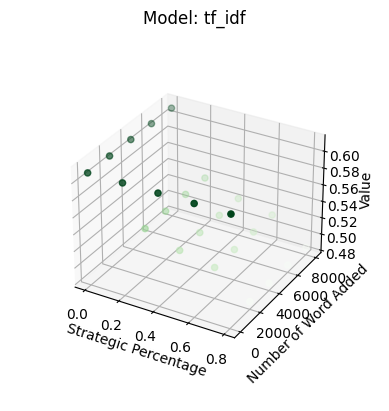

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


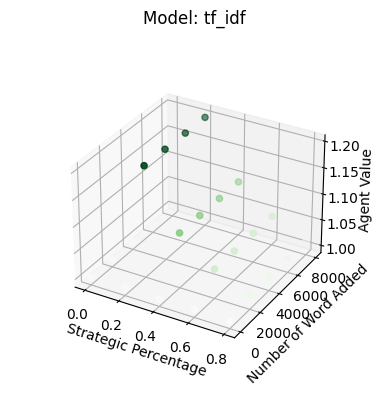

In [16]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf", strategy="dominant_word_not_present")

In our first experiment employed the TF-IDF model utilizing the dominant_word_not_present strategy. The findings indicate that the system value is highest when none of the agents are strategic, which occurs when the percentage of strategic agents or added words is equal to zero. Subsequently, an increase in the number of agents magnifies the effect of the decrease in the system value, as the system becomes increasingly disrupted. Additionally, the agents consistently generate profits, with their value consistently higher than 1. A higher number of added words results in a greater value for the agents since they are more likely to add a non-existent word, thereby increasing the document's relevance. But a higher percentage of strategic agents results in a lower value for the agents since they are starting to harm each other's profits.


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: dominant_word_not_present	k: 4


100%|██████████| 5/5 [15:09<00:00, 181.99s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


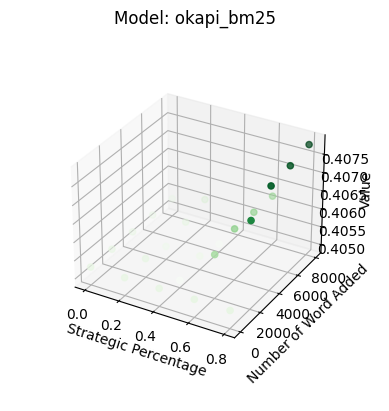

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


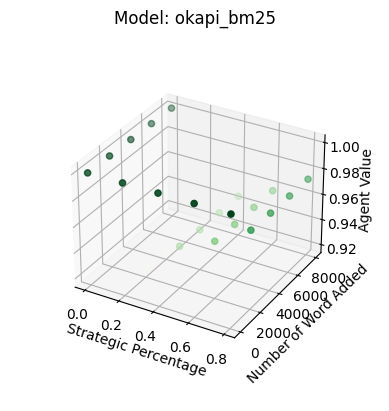

In [17]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "okapi_bm25", strategy="dominant_word_not_present")

I have no idea what to write here


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 1


100%|██████████| 5/5 [38:35<00:00, 463.07s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


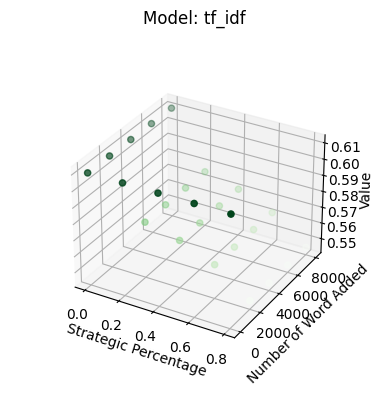

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


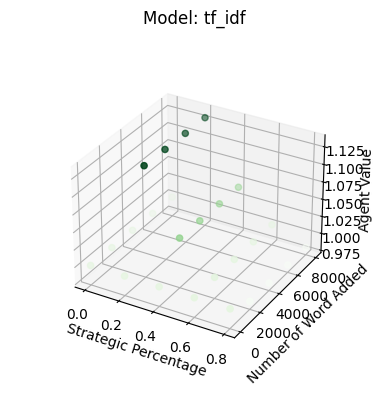


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 2


100%|██████████| 5/5 [38:47<00:00, 465.59s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


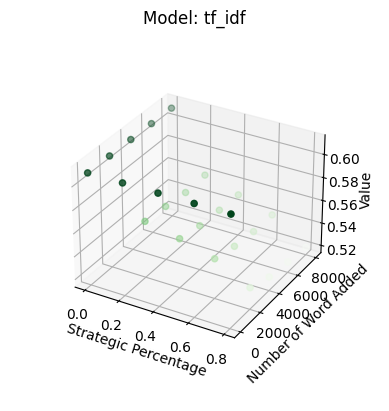

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


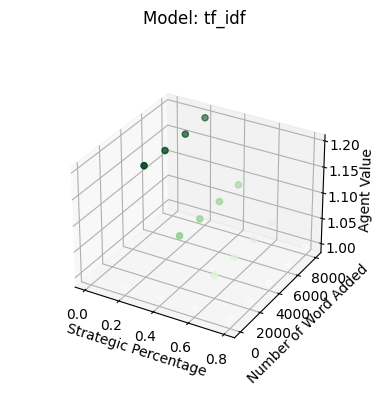


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 3


100%|██████████| 5/5 [38:53<00:00, 466.69s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


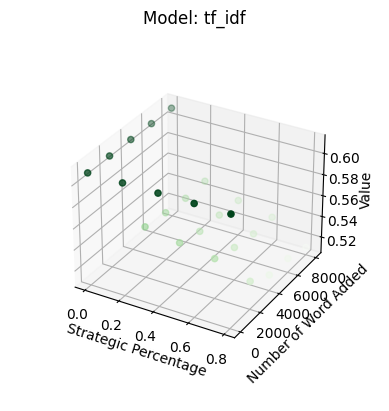

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


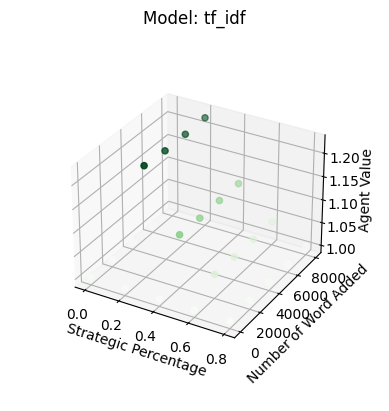


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


100%|██████████| 5/5 [39:04<00:00, 468.81s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


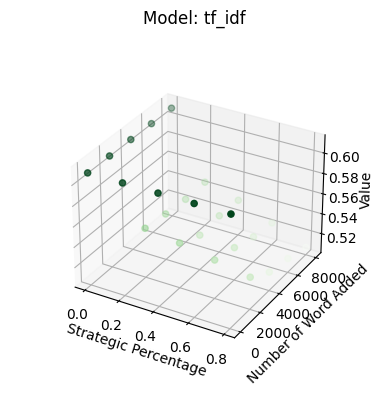

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


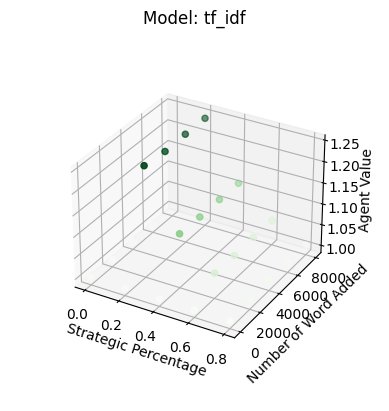

In [18]:
for k in range(1, 5):
    run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf", k=k, strategy="top_k_softmax")

In this experiment, the TF-IDF model was employed once again, albeit utilizing the top_k_softmax approach. The results obtained were analogous to those previously observed, with slight discrepancies in the values but upheld order relations, thereby permitting the same inferences to be made. The consistent findings across the aforementioned experiments employing distinct methodologies suggests the robustness of the system, with a heightened level of confidence.


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 1


100%|██████████| 5/5 [19:01<00:00, 228.21s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


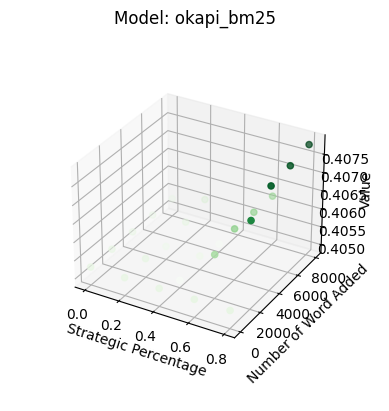

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


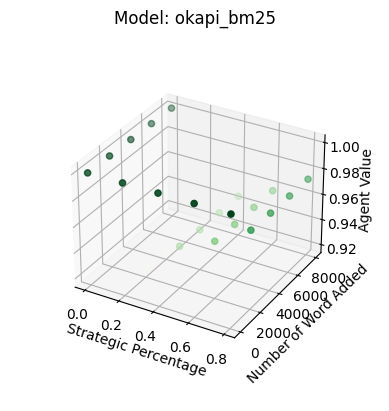


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 2


100%|██████████| 5/5 [19:12<00:00, 230.44s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


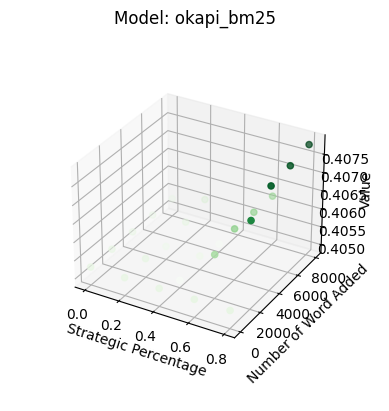

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


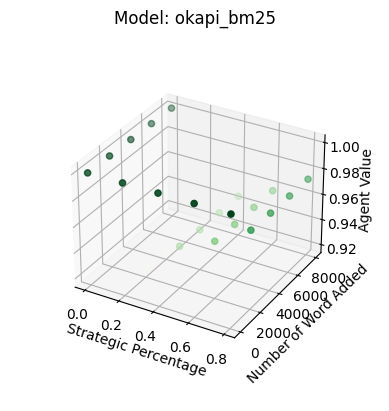


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 3


100%|██████████| 5/5 [19:22<00:00, 232.55s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


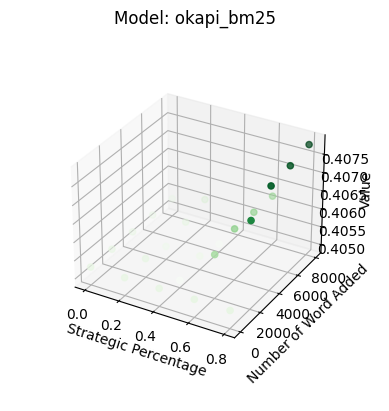

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


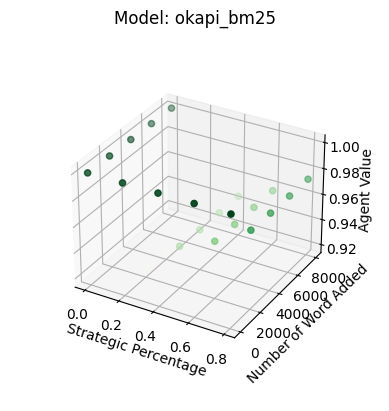


Model: okapi_bm25	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


100%|██████████| 5/5 [19:26<00:00, 233.30s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


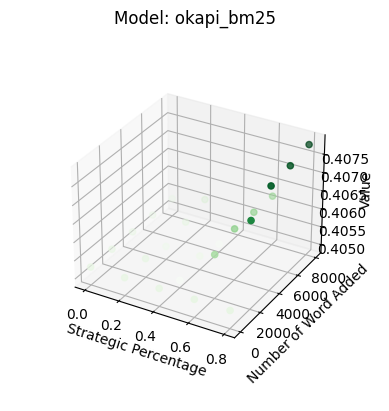

C:\Users\idozu\AppData\Local\Temp\ipykernel_13768\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


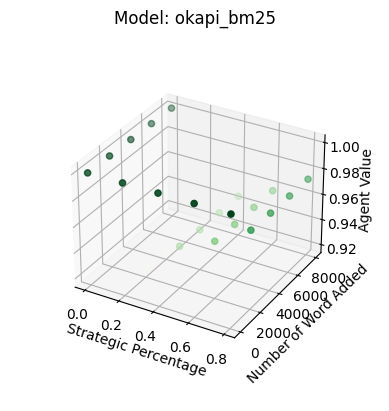

In [19]:
for k in range(1, 5):
    run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "okapi_bm25", k=k, strategy="top_k_softmax")

I have no idea what to write here


Model: tf_idf	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


100%|██████████| 5/5 [44:14<00:00, 530.83s/it]
C:\Users\idozu\AppData\Local\Temp\ipykernel_10512\3990933853.py:76: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


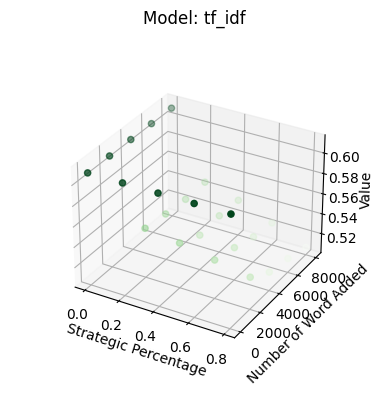

C:\Users\idozu\AppData\Local\Temp\ipykernel_10512\3990933853.py:90: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


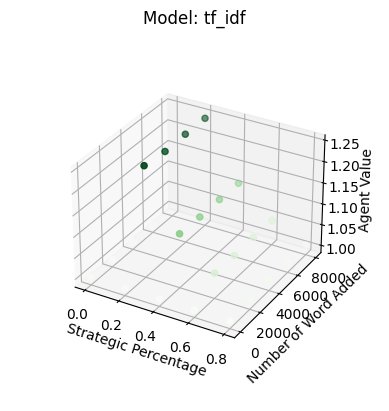

In [5]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "tf_idf")

In [ ]:
run_exp(np.arange(0, 1, 0.2), range(0, 10000, 2000), "rank_svm")


Model: rank_svm	strategic_per: [0.  0.2 0.4 0.6 0.8]	number_of_word_to_add: range(0, 10000, 2000)	strategy: top_k_softmax	k: 4


 40%|████      | 2/5 [1:17:33<1:59:27, 2389.16s/it]

## Discussion
?????

## Limitations
?????